In [ ]:
from google.colab import drive
from google.colab import files
import torch
import os
import torch.nn as nn
import shutil
import cv2
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import random
from collections import defaultdict
from torchvision.utils import make_grid

drive.mount('/content/drive')
workspace_path = '/content/drive/MyDrive/GreyToColour/'
os.chdir(workspace_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
main_folder = "/content/drive/MyDrive/GreyToColour/data/data/"

# Klasörlerin isimlerini belirtin
folders = ["Flowers", "Cars"]

total_count=0

for folder_name in folders:
    folder_path = os.path.join(main_folder, folder_name)
    sub_folders = ["grey", "colour"]
    for sub_folder_name in sub_folders:
        sub_folder_path = os.path.join(folder_path, sub_folder_name)
        files = os.listdir(sub_folder_path)
        total_count+=len(files)
dataset_name = "Flowers + Cars"
print(f"{dataset_name} Veri seti Boyutu:", total_count)


Flowers + Cars Veri seti Boyutu: 800


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.files_grey = sorted(os.listdir(os.path.join(root, 'grey')))
        self.files_colour = sorted(os.listdir(os.path.join(root, 'colour')))
        self.root_grey = os.path.join(root, 'grey')
        self.root_colour = os.path.join(root, 'colour')

    def __len__(self):
        return len(self.files_grey)

    def __getitem__(self, index):
        img_grey = Image.open(os.path.join(self.root_grey, self.files_grey[index])).convert('L')
        img_colour = Image.open(os.path.join(self.root_colour, self.files_colour[index])).convert('RGB')

        if self.transform:
            img_grey = self.transform(img_grey)
            img_colour = self.transform(img_colour)

        #print(img_grey.shape)
        #print(img_colour.shape)

        img_np_grey = np.array(img_grey.permute(1, 2, 0))  # Convert to HWC format
        img_np_colour = np.array(img_colour.permute(1, 2, 0))  # Convert to HWC format

        img_np_grey = (img_np_grey * 255).astype(np.uint8)
        img_np_colour = (img_np_colour * 255).astype(np.uint8)

        #print(img_np_grey.shape)
        #cv2_imshow(img_np_grey)

        #print(img_np_colour.shape)
        #cv2_imshow(img_np_colour)

        #print(type(img_np_grey))
        #print(type(img_np_colour))


        return {'grey':img_grey, 'colour':img_colour}


(128, 128, 3)


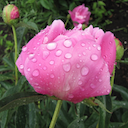

In [ ]:
from google.colab.patches import cv2_imshow
root_dir = '/content/drive/MyDrive/GreyToColour/gray_to_colour_data/'

# burada normalde grayscale görüntünün channel sayısı kaç onu kontrol ettim
# I checked the channel size of grayscale image before the transformation
img = cv2.imread('/content/drive/MyDrive/GreyToColour/gray_to_colour_data/train/colour/0040.png')
print(img.shape)
cv2_imshow(img)

# Eğitim veri seti
train_dataset = ImageDataset(root=os.path.join(root_dir, 'train'), transform=transform)
img = train_dataset[250]
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Doğrulama veri seti
val_dataset = ImageDataset(root=os.path.join(root_dir, 'validation'), transform=transform)
img = val_dataset[3]
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# Test veri seti
test_dataset = ImageDataset(root=os.path.join(root_dir, 'test'), transform=transform)
img = test_dataset[7]
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_size, out_size):
        super(Encoder, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, stride=2, padding=1),
                  nn.LeakyReLU(0.2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, in_size, out_size):
        super(Decoder, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, stride=2, padding=1, bias=False),
            #nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            #nn.Conv2d(in_size, out_size, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_size),
            nn.ReLU(inplace=True)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        # print("Shape of x:", x.shape)
        # print("Shape of skip_input:", skip_input.shape)

        # x = F.interpolate(x, size=skip_input.shape[2:], mode='bilinear', align_corners=False)

        x = torch.cat((x, skip_input), 1)
        return x

In [ ]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = Encoder(in_channels, 64)
        self.down2 = Encoder(64, 128)
        self.down3 = Encoder(128, 256)
        self.down4 = Encoder(256, 512)
        self.down5 = Encoder(512, 512)
        self.down6 = Encoder(512, 512)
        self.down7 = Encoder(512, 512)
        self.down8 = Encoder(512, 512)

        self.up1 = Decoder(512, 512)
        self.up2 = Decoder(1024, 512)
        self.up3 = Decoder(1024, 512)
        self.up4 = Decoder(1024, 512)
        self.up5 = Decoder(1024, 256)
        self.up6 = Decoder(512, 128)
        self.up7 = Decoder(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        u8 = self.final(u7)

        return u8

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels_A=1, in_channels_B=3):
        super(Discriminator, self).__init__()

        self.img_A_conv = nn.Conv2d(in_channels_A, in_channels_B, kernel_size=1)

        def discriminator_block(in_filters, out_filters):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels_B * 2, 64),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img_A, img_B):
        img_A = self.img_A_conv(img_A)
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [ ]:
loss_comparison = nn.BCEWithLogitsLoss()
L1_loss = nn.L1Loss()
generator = GeneratorUNet()

In [ ]:
def discriminator_training(inputs, targets, discriminator_opt):
  discriminator_opt.zero_grad()

  # passing real image and getting loss
  output = discriminator(inputs, targets)
  label = torch.ones(size=output.shape, dtype=torch.float, device=device)

  real_loss = loss_comparison(output, label)

  # passing generated image and getting loss

  gen_image = generator(inputs).detach()

  fake_output = discriminator(inputs, gen_image)
  fake_label = torch.zeros(size=fake_output.shape, dtype=torch.float, device=device)

  fake_loss = loss_comparison(fake_output, fake_label)

  total_loss = (real_loss + fake_loss)/2

  total_loss.backward()

  discriminator_opt.step()

  return total_loss

In [ ]:
def generator_training(inputs, targets, generator_opt, L1_lambda):
  generator_opt.zero_grad()

  generated_image = generator(inputs)
  disc_output = discriminator(inputs, generated_image)
  desired_output = torch.ones(size=disc_output.shape, dtype=torch.float, device=device)
  # desired_output = torch.ones_like(disc_output)

  # generator_loss = loss_comparison(disc_output, desired_output) + L1_lambda * torch.abs(generated_image-targets).sum()
  generator_loss = loss_comparison(disc_output, desired_output) + L1_lambda * L1_loss(generated_image, targets)
  generator_loss.backward()
  generator_opt.step()

  return generator_loss, generated_image

In [ ]:
def DeNormalize(tensor_of_image):
  return tensor_of_image * 0.5 + 0.5

In [ ]:

def print_images(image_tensor, num_images):

    images = DeNormalize(image_tensor)
    images = images.detach().cpu()
    image_grid = make_grid(images[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

In [ ]:
L1_lambda = 50
num_epochs = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
discriminator = Discriminator()
discriminator.to(device)


Discriminator(
  (img_A_conv): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): ZeroPad2d((1, 0, 1, 0))
    (9): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [ ]:

discriminator_opt = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
generator_opt = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

discriminator = discriminator.to(device)
generator = generator.to(device)

Epoch: 1/100 Loss D: 0.6956440210342407, Loss G: 5.182455062866211


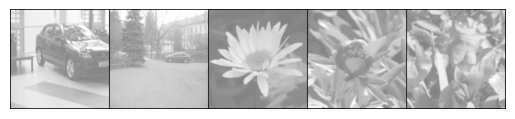

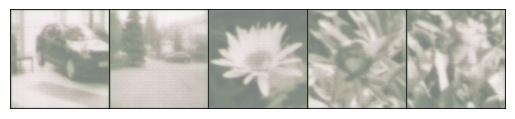

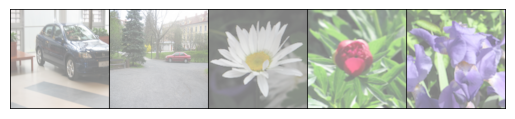

Validation Loss: 0.6921724200248718
Epoch: 2/100 Loss D: 0.6988006830215454, Loss G: 4.365005016326904
Validation Loss: 0.7024066925048829
Epoch: 3/100 Loss D: 0.6926231980323792, Loss G: 4.919917106628418
Validation Loss: 0.698666763305664
Epoch: 4/100 Loss D: 0.7006495594978333, Loss G: 4.239850044250488
Validation Loss: 0.6943612098693848
Epoch: 5/100 Loss D: 0.6515464782714844, Loss G: 4.411015033721924
Validation Loss: 0.7063849329948425
Epoch: 6/100 Loss D: 0.6592325568199158, Loss G: 4.235406398773193


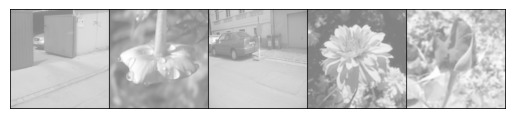

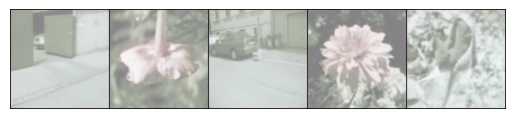

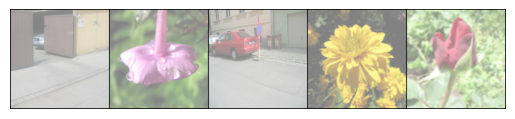

Validation Loss: 0.6973894476890564
Epoch: 7/100 Loss D: 0.6816971302032471, Loss G: 5.008838653564453
Validation Loss: 0.6984034061431885
Epoch: 8/100 Loss D: 0.6523643732070923, Loss G: 3.6309635639190674
Validation Loss: 0.6966533780097961
Epoch: 9/100 Loss D: 0.6931924223899841, Loss G: 3.75278377532959
Validation Loss: 0.7036496996879578
Epoch: 10/100 Loss D: 0.6850597858428955, Loss G: 3.1316325664520264
Validation Loss: 0.6965394139289856
Epoch: 11/100 Loss D: 0.674765944480896, Loss G: 4.569005489349365


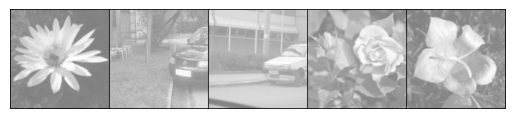

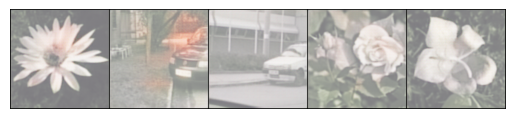

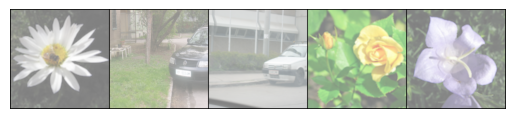

Validation Loss: 0.6917238593101501
Epoch: 12/100 Loss D: 0.6511735916137695, Loss G: 3.0498251914978027
Validation Loss: 0.6916500926017761
Epoch: 13/100 Loss D: 0.7351809144020081, Loss G: 3.6266403198242188
Validation Loss: 0.7034255266189575
Epoch: 14/100 Loss D: 0.6612933874130249, Loss G: 2.507145404815674
Validation Loss: 0.7009551167488098
Epoch: 15/100 Loss D: 0.7787812352180481, Loss G: 4.590954780578613
Validation Loss: 0.6950494170188903
Epoch: 16/100 Loss D: 0.6889054775238037, Loss G: 3.255451202392578


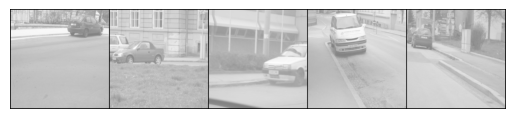

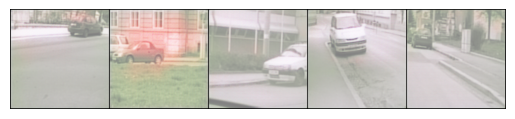

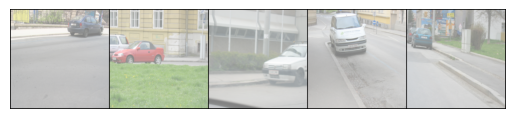

Validation Loss: 0.6996194362640381
Epoch: 17/100 Loss D: 0.6643751859664917, Loss G: 3.451528787612915
Validation Loss: 0.7000413417816163
Epoch: 18/100 Loss D: 0.9450579881668091, Loss G: 3.6227192878723145
Validation Loss: 0.7002242684364319
Epoch: 19/100 Loss D: 0.6935901641845703, Loss G: 2.2317252159118652
Validation Loss: 0.6981024503707886
Epoch: 20/100 Loss D: 0.689228892326355, Loss G: 5.616990566253662
Validation Loss: 0.6987032532691956
Epoch: 21/100 Loss D: 0.6802462935447693, Loss G: 3.086366653442383


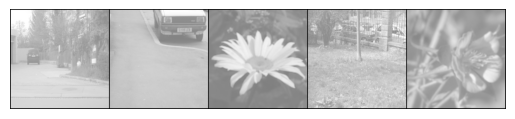

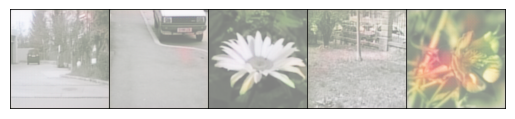

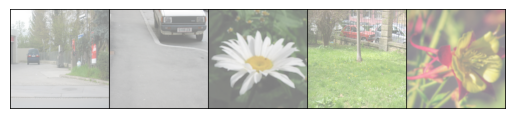

Validation Loss: 0.6955394864082336
Epoch: 22/100 Loss D: 0.6891771554946899, Loss G: 3.738281726837158
Validation Loss: 0.6962991833686829
Epoch: 23/100 Loss D: 0.6887097954750061, Loss G: 2.674050807952881
Validation Loss: 0.695805549621582
Epoch: 24/100 Loss D: 0.6938085556030273, Loss G: 2.548654794692993
Validation Loss: 0.6961405515670777
Epoch: 25/100 Loss D: 0.6716466546058655, Loss G: 3.763645887374878
Validation Loss: 0.6940166354179382
Epoch: 26/100 Loss D: 0.6899705529212952, Loss G: 3.213505268096924


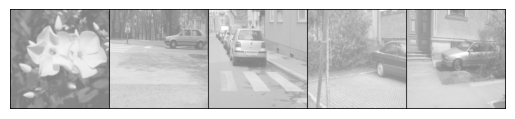

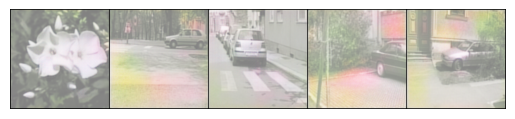

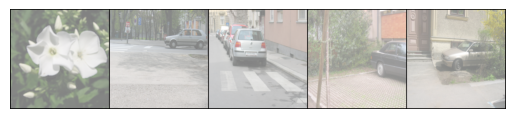

Validation Loss: 0.6970134019851685
Epoch: 27/100 Loss D: 0.6834285259246826, Loss G: 2.578693389892578
Validation Loss: 0.6915056228637695
Epoch: 28/100 Loss D: 0.7074265480041504, Loss G: 3.4904332160949707
Validation Loss: 0.6954862594604492
Epoch: 29/100 Loss D: 0.6755859851837158, Loss G: 2.9863381385803223
Validation Loss: 0.6984348297119141
Epoch: 30/100 Loss D: 0.6963868737220764, Loss G: 2.7074034214019775
Validation Loss: 0.6953633189201355
Epoch: 31/100 Loss D: 0.6901392936706543, Loss G: 2.9379866123199463


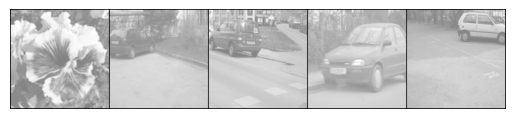

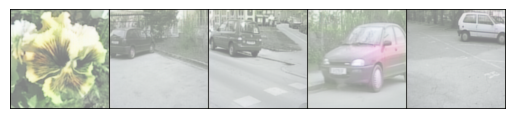

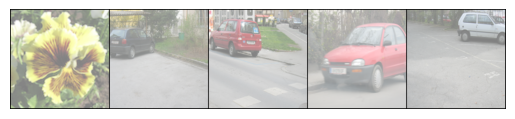

Validation Loss: 0.6959097504615783
Epoch: 32/100 Loss D: 0.6855731010437012, Loss G: 2.7072064876556396
Validation Loss: 0.6957555174827575
Epoch: 33/100 Loss D: 0.6900137662887573, Loss G: 2.6665141582489014
Validation Loss: 0.6938506722450256
Epoch: 34/100 Loss D: 0.691406786441803, Loss G: 2.6000561714172363
Validation Loss: 0.6967221736907959
Epoch: 35/100 Loss D: 0.6961893439292908, Loss G: 2.5085437297821045
Validation Loss: 0.6951393842697143
Epoch: 36/100 Loss D: 0.6959003210067749, Loss G: 3.696215867996216


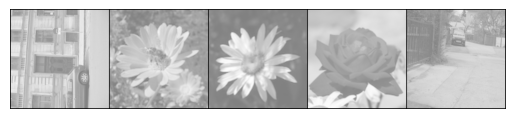

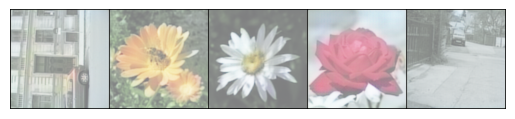

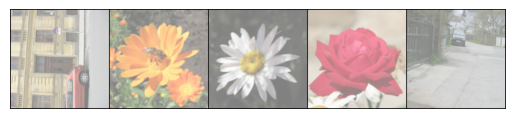

Validation Loss: 0.6924489259719848
Epoch: 37/100 Loss D: 0.6686252355575562, Loss G: 2.6881561279296875
Validation Loss: 0.6924777269363404
Epoch: 38/100 Loss D: 0.6850463151931763, Loss G: 1.930299997329712
Validation Loss: 0.6961981058120728
Epoch: 39/100 Loss D: 0.6880823373794556, Loss G: 3.30855655670166
Validation Loss: 0.6947954893112183
Epoch: 40/100 Loss D: 0.6751675605773926, Loss G: 2.648284435272217
Validation Loss: 0.6943414807319641
Epoch: 41/100 Loss D: 0.6990605592727661, Loss G: 2.5489583015441895


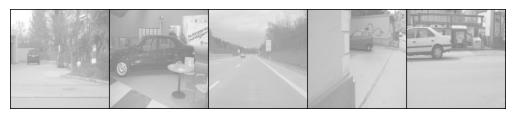

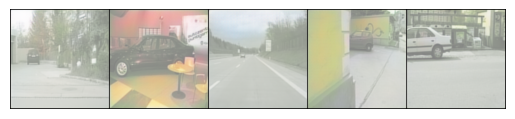

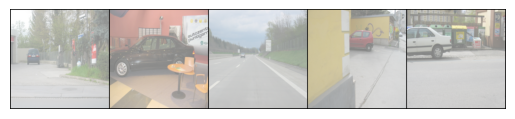

Validation Loss: 0.6972464919090271
Epoch: 42/100 Loss D: 0.6762305498123169, Loss G: 2.699739456176758
Validation Loss: 0.6954054832458496
Epoch: 43/100 Loss D: 0.6978166103363037, Loss G: 2.43508243560791
Validation Loss: 0.692666482925415
Epoch: 44/100 Loss D: 0.698177695274353, Loss G: 2.230149745941162
Validation Loss: 0.6950190186500549
Epoch: 45/100 Loss D: 0.7003458738327026, Loss G: 2.4722962379455566
Validation Loss: 0.6948347687721252
Epoch: 46/100 Loss D: 0.6762213110923767, Loss G: 3.1797969341278076


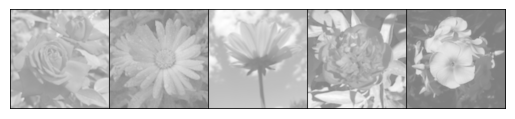

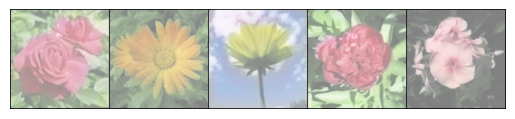

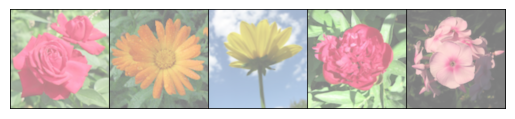

Validation Loss: 0.693958044052124
Epoch: 47/100 Loss D: 0.6716792583465576, Loss G: 2.29974365234375
Validation Loss: 0.6959528923034668
Epoch: 48/100 Loss D: 0.689994215965271, Loss G: 2.2259085178375244
Validation Loss: 0.6966838002204895
Epoch: 49/100 Loss D: 0.703261137008667, Loss G: 2.426769971847534
Validation Loss: 0.6933945417404175
Epoch: 50/100 Loss D: 0.6885071992874146, Loss G: 2.0260086059570312
Validation Loss: 0.6956815361976624
Epoch: 51/100 Loss D: 0.6730685234069824, Loss G: 3.29921293258667


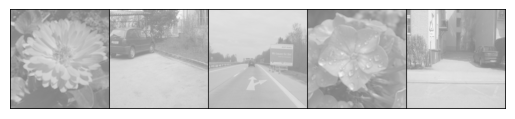

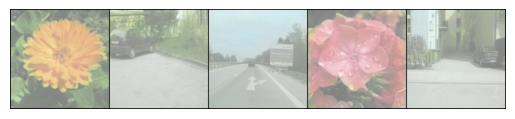

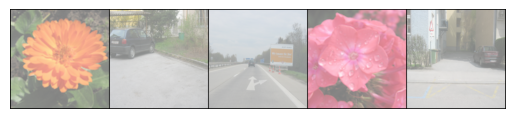

Validation Loss: 0.6949642777442933
Epoch: 52/100 Loss D: 0.6947776079177856, Loss G: 2.145413398742676
Validation Loss: 0.6953355312347412
Epoch: 53/100 Loss D: 0.6529811024665833, Loss G: 2.746506690979004
Validation Loss: 0.6939139723777771
Epoch: 54/100 Loss D: 0.6978613138198853, Loss G: 1.9942140579223633
Validation Loss: 0.6943959832191468
Epoch: 55/100 Loss D: 0.7023335099220276, Loss G: 2.147043228149414
Validation Loss: 0.69550119638443
Epoch: 56/100 Loss D: 0.6993390321731567, Loss G: 2.153749465942383


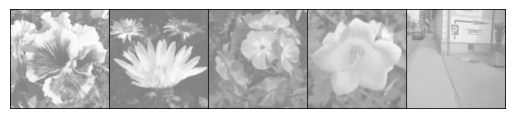

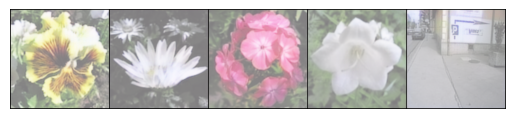

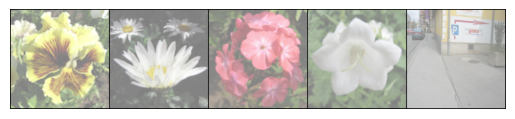

Validation Loss: 0.6952171206474305
Epoch: 57/100 Loss D: 0.6886255741119385, Loss G: 2.101722240447998
Validation Loss: 0.694319236278534
Epoch: 58/100 Loss D: 0.6806021928787231, Loss G: 2.2351596355438232
Validation Loss: 0.6949525475502014
Epoch: 59/100 Loss D: 0.699235737323761, Loss G: 2.089557647705078
Validation Loss: 0.6958082318305969
Epoch: 60/100 Loss D: 0.6896346211433411, Loss G: 2.5328173637390137
Validation Loss: 0.6932759642601013
Epoch: 61/100 Loss D: 0.7160438895225525, Loss G: 2.214456796646118


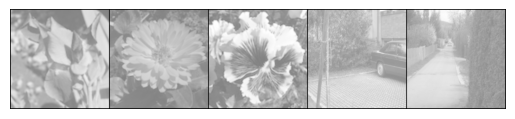

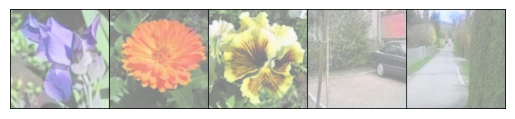

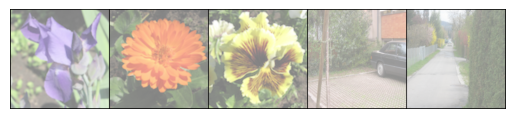

Validation Loss: 0.6955771446228027
Epoch: 62/100 Loss D: 0.6823192834854126, Loss G: 2.297273635864258
Validation Loss: 0.6948208808898926
Epoch: 63/100 Loss D: 0.6845348477363586, Loss G: 2.17746901512146
Validation Loss: 0.6960676670074463
Epoch: 64/100 Loss D: 0.6980842351913452, Loss G: 1.986556053161621
Validation Loss: 0.6941948533058167
Epoch: 65/100 Loss D: 0.6879599094390869, Loss G: 2.4019763469696045
Validation Loss: 0.6945672392845154
Epoch: 66/100 Loss D: 0.6997798085212708, Loss G: 2.7297723293304443


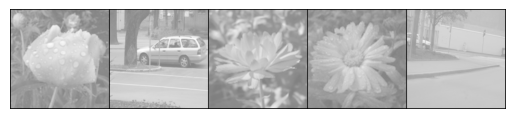

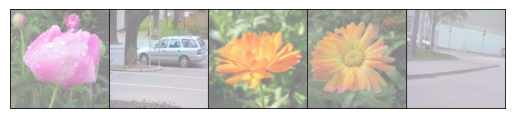

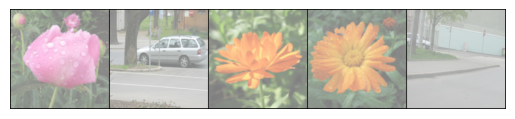

Validation Loss: 0.6959001421928406
Epoch: 67/100 Loss D: 0.6840940713882446, Loss G: 2.3179972171783447
Validation Loss: 0.6939594268798828
Epoch: 68/100 Loss D: 0.6882117390632629, Loss G: 2.2201271057128906
Validation Loss: 0.6945019364356995
Epoch: 69/100 Loss D: 0.6910538673400879, Loss G: 2.1343870162963867
Validation Loss: 0.6936855792999268
Epoch: 70/100 Loss D: 0.6904466152191162, Loss G: 1.9774343967437744
Validation Loss: 0.6941646814346314
Epoch: 71/100 Loss D: 0.6884461641311646, Loss G: 1.8280980587005615


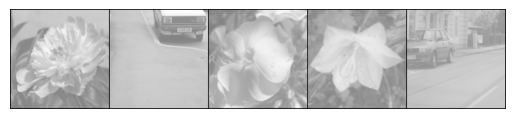

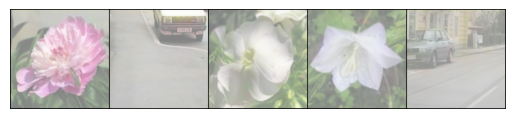

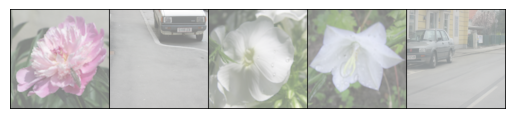

Validation Loss: 0.6962870717048645
Epoch: 72/100 Loss D: 0.6898574829101562, Loss G: 2.11271333694458
Validation Loss: 0.6952344059944153
Epoch: 73/100 Loss D: 0.6861572265625, Loss G: 2.267625331878662
Validation Loss: 0.6952256202697754
Epoch: 74/100 Loss D: 0.6887273788452148, Loss G: 1.7830836772918701
Validation Loss: 0.6952220320701599
Epoch: 75/100 Loss D: 0.6835978031158447, Loss G: 2.0747921466827393
Validation Loss: 0.6946372151374817
Epoch: 76/100 Loss D: 0.6947425603866577, Loss G: 1.9088561534881592


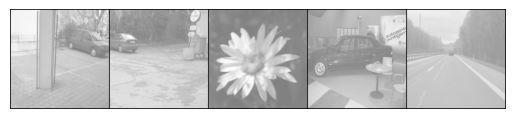

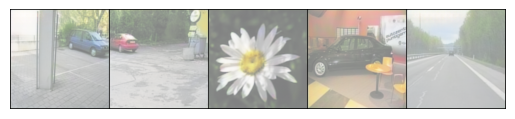

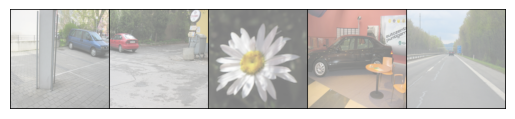

Validation Loss: 0.694575560092926
Epoch: 77/100 Loss D: 0.6912181377410889, Loss G: 1.654082179069519
Validation Loss: 0.6952980637550354
Epoch: 78/100 Loss D: 0.6832411289215088, Loss G: 2.2273271083831787
Validation Loss: 0.6938835263252259
Epoch: 79/100 Loss D: 0.690815806388855, Loss G: 2.11188006401062
Validation Loss: 0.6946431756019592
Epoch: 80/100 Loss D: 0.6779080033302307, Loss G: 2.288109302520752
Validation Loss: 0.6967419266700745
Epoch: 81/100 Loss D: 0.6939167380332947, Loss G: 2.1318299770355225


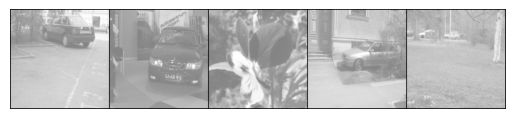

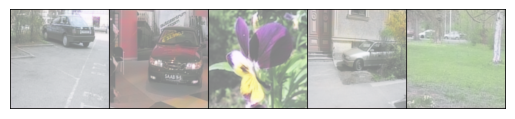

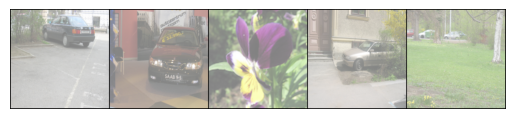

Validation Loss: 0.6947912454605103
Epoch: 82/100 Loss D: 0.7071619033813477, Loss G: 1.8638396263122559
Validation Loss: 0.694480013847351
Epoch: 83/100 Loss D: 0.6828252077102661, Loss G: 2.182529926300049
Validation Loss: 0.6934016704559326
Epoch: 84/100 Loss D: 0.7057764530181885, Loss G: 1.8870313167572021
Validation Loss: 0.6938953399658203
Epoch: 85/100 Loss D: 0.6994324922561646, Loss G: 2.0828022956848145
Validation Loss: 0.6943545460700988
Epoch: 86/100 Loss D: 0.6969317197799683, Loss G: 2.232684850692749


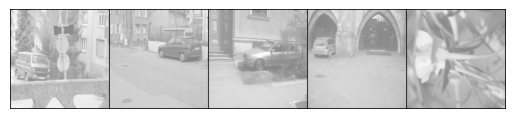

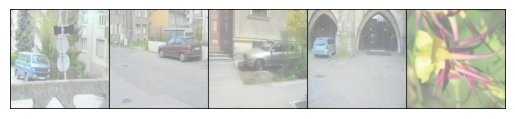

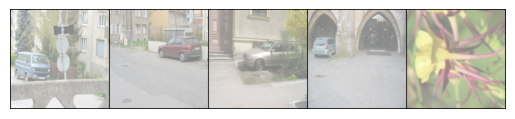

Validation Loss: 0.6982248306274415
Epoch: 87/100 Loss D: 0.687296986579895, Loss G: 2.431976556777954
Validation Loss: 0.6940518617630005
Epoch: 88/100 Loss D: 0.6911993026733398, Loss G: 1.9755945205688477
Validation Loss: 0.6944807767868042
Epoch: 89/100 Loss D: 0.6898220777511597, Loss G: 1.7347904443740845
Validation Loss: 0.695629608631134
Epoch: 90/100 Loss D: 0.6904456615447998, Loss G: 1.7025469541549683
Validation Loss: 0.6953807830810547
Epoch: 91/100 Loss D: 0.6955007910728455, Loss G: 1.8816936016082764


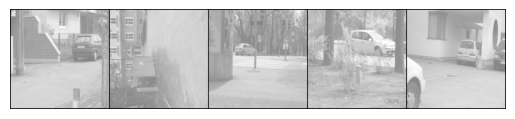

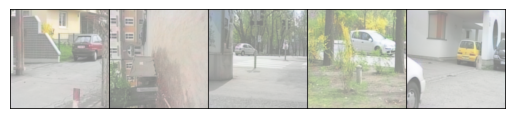

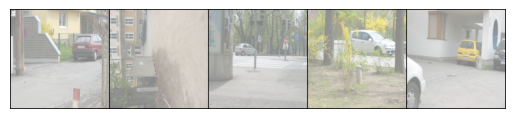

Validation Loss: 0.6949527859687805
Epoch: 92/100 Loss D: 0.688685417175293, Loss G: 1.98038911819458
Validation Loss: 0.694700825214386
Epoch: 93/100 Loss D: 0.6945176124572754, Loss G: 1.9454641342163086
Validation Loss: 0.6953260421752929
Epoch: 94/100 Loss D: 0.6986993551254272, Loss G: 1.867067813873291
Validation Loss: 0.6947734951972961
Epoch: 95/100 Loss D: 0.690032958984375, Loss G: 1.8338561058044434
Validation Loss: 0.6938453197479248
Epoch: 96/100 Loss D: 0.6579603552818298, Loss G: 2.2446084022521973


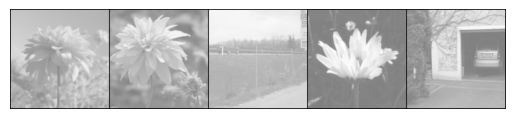

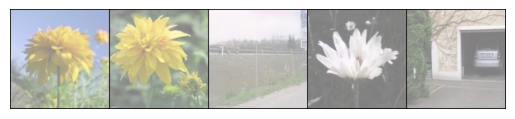

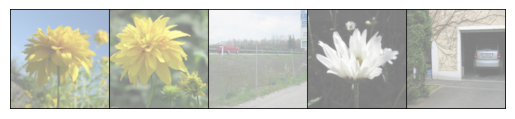

Validation Loss: 0.6962868571281433
Epoch: 97/100 Loss D: 0.6918977499008179, Loss G: 2.07991886138916
Validation Loss: 0.6954145073890686
Epoch: 98/100 Loss D: 0.6938018798828125, Loss G: 1.992055892944336
Validation Loss: 0.6938822388648986
Epoch: 99/100 Loss D: 0.6911112070083618, Loss G: 1.9506936073303223
Validation Loss: 0.6946158409118652
Epoch: 100/100 Loss D: 0.6820818185806274, Loss G: 2.2544565200805664
Validation Loss: 0.6947558999061585


In [ ]:
for epoch in range(num_epochs):
  discriminator.train()
  generator.train()
  for batch in train_loader:
    grey_batch = batch['grey'].to(device).float()
    colour_batch = batch['colour'].to(device).float()

    Disc_Loss = discriminator_training(grey_batch, colour_batch, discriminator_opt)

    Gen_Loss, generator_image = generator_training(grey_batch, colour_batch, generator_opt, L1_lambda)

  print(f"Epoch: {epoch+1}/{num_epochs} Loss D: {Disc_Loss}, Loss G: {Gen_Loss}")
  if (epoch % 5) == 0:
         print_images(grey_batch,5)
         print_images(generator_image,5)
         print_images(colour_batch,5)
  discriminator.eval()
  generator.eval()
  val_loss = 0
  with torch.no_grad():
    for batch in val_loader:
        grey_batch = batch['grey'].to(device).float()
        colour_batch = batch['colour'].to(device).float()

        fake_colour = generator(grey_batch)
        Gen_Loss = loss_comparison(fake_colour, colour_batch)

        val_loss += Gen_Loss.item()  # Validation kaybını toplama

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss}")




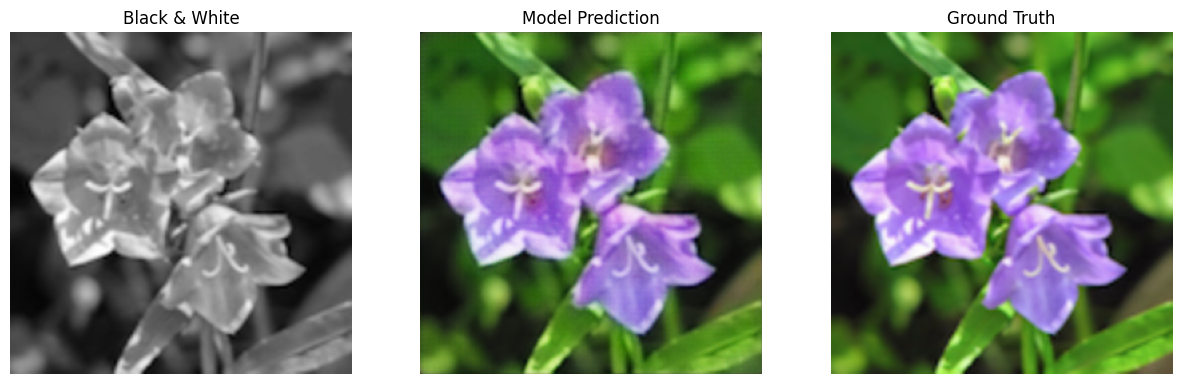

In [ ]:
def imshow(image, title=None, cmap=None):
    """ Helper function to display an image tensor. """
    # image is a numpy array already
    plt.imshow(image, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis('off')

# Test aşaması
generator.eval()
with torch.no_grad():
    # Get one batch from the test_loader
    for batch in train_loader:
        grey_batch = batch['grey'].to(device).float()
        colour_batch = batch['colour'].to(device).float()
        outputs = generator(grey_batch)

        # Take the first image in the batch
        grey_image = grey_batch[0]
        color_image = colour_batch[0]
        output_image = outputs[0]

        # Move tensors to CPU and normalize to [0, 1]
        grey_image = grey_image.cpu().numpy().transpose(1, 2, 0)
        grey_image = np.clip(grey_image, 0, 1)

        color_image = color_image.cpu().numpy().transpose(1, 2, 0)
        color_image = np.clip(color_image, 0, 1)

        output_image = output_image.cpu().numpy().transpose(1, 2, 0)
        output_image = np.clip(output_image, 0, 1)

        # Plotting
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        imshow(grey_image, 'Black & White', cmap='gray')

        plt.subplot(1, 3, 2)
        imshow(output_image, 'Model Prediction')

        plt.subplot(1, 3, 3)
        imshow(color_image, 'Ground Truth')

        plt.show()
        break  # Only display the first example